# Render PGN to images

# Imports

In [1]:
import chess
import chess.pgn
import chess.svg
import cairosvg
import requests
from pprint import pprint
import io
import os
import json
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import random
from sklearn.model_selection import train_test_split

from PIL import Image, ImageDraw, ImageFilter

 # Get games from user

In [3]:
players_usernames = ["Hikaru", "magnuscarlsen", "firouzja2003", "gukeshdommaraju", "lachesisq", "fabianocaruana", "hansontwitch"]

username = "Hikaru"
year = "2025"
month = "01"

headers = {
    "Content-Type": "application/json",
    "User-Agent": "chess-api-test/0.1 (username: AlexCQJ; contact: alex.c.quiroga.jaldin@gmail.com)"
}

url = f"https://api.chess.com/pub/player/{username}/games/{year}/{month}"
response = requests.get(url, headers=headers)
if response.status_code == 200:
    player_games_archive = response.json()
    print("Keys: ", player_games_archive.keys())
    print("games keys: ", player_games_archive["games"][0].keys())
    print("Number of games: ", len(player_games_archive["games"]))
    selected_games = player_games_archive["games"]
    pprint(selected_games[0])
else:
    print(f"Error fetching games archive for {username} in {year}-{month}: {response.status_code}")

Keys:  dict_keys(['games'])
games keys:  dict_keys(['url', 'pgn', 'time_control', 'end_time', 'rated', 'accuracies', 'tcn', 'uuid', 'initial_setup', 'fen', 'time_class', 'rules', 'white', 'black', 'eco'])
Number of games:  485
{'accuracies': {'black': 88.07, 'white': 92.57},
 'black': {'@id': 'https://api.chess.com/pub/player/hikaru',
           'rating': 3282,
           'result': 'resigned',
           'username': 'Hikaru',
           'uuid': '6f4deb88-7718-11e3-8016-000000000000'},
 'eco': 'https://www.chess.com/openings/Modern-Defense-with-1-e4-2.d4',
 'end_time': 1735949652,
 'fen': '8/3P4/p5k1/8/2p5/P1K3p1/8/8 w - -',
 'initial_setup': 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1',
 'pgn': '[Event "Live Chess"]\n'
        '[Site "Chess.com"]\n'
        '[Date "2025.01.04"]\n'
        '[Round "-"]\n'
        '[White "Arystanner"]\n'
        '[Black "Hikaru"]\n'
        '[Result "1-0"]\n'
        '[CurrentPosition "8/3P4/p5k1/8/2p5/P1K3p1/8/8 w - -"]\n'
        '[Timez

## Get games from event

In [2]:
tournament_url_id = "late-titled-tuesday-blitz-may-13-2025-5643227"

headers = {
    "Content-Type": "application/json",
    "User-Agent": "chess-api-test/0.1 (username: AlexCQJ; contact: alex.c.quiroga.jaldin@gmail.com)"
}

def get_tournament_rounds(tournament_url_id):
    url = f"https://api.chess.com/pub/tournament/{tournament_url_id}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        tournament_details = response.json()
        print("==== Tournament Details ====")
        print("Keys: ", tournament_details.keys())
        print("Name: ", tournament_details["name"])
        print("Number of players: ", len(tournament_details["players"]))
        print("Number of rounds: ", len(tournament_details["rounds"]))
        rounds_urls = tournament_details["rounds"]
        return rounds_urls
    else:
        print(f"Error fetching tournament details for {url_id}: {response.status_code}")
        return []
        
    
def get_tournament_round_groups(round_urls):
    groups_urls = []
    
    for round_url in tqdm(round_urls):
        response = requests.get(round_url, headers=headers)
        if response.status_code == 200:
            round_details = response.json()
            groups_urls += round_details.get("groups", [])
            print(f"Number of groups in round {round_url}: {len(groups_urls)}")
        else:
            print(f"Error fetching round details for {round_url}: {response.status_code}")
    return groups_urls


def get_games_in_rounds(round_urls):
    games = []
    
    for round_url in tqdm(round_urls):
        response = requests.get(round_url, headers=headers)
        if response.status_code == 200:
            round_details = response.json()
            games += round_details.get("games", [])
        else:
            print(f"Error fetching round details for {round_url}: {response.status_code}")
            
    print(f"Total number of games in all rounds: {len(games)}")
    return games
    
rounds_urls = get_tournament_rounds(tournament_url_id)
groups_urls = get_tournament_round_groups(rounds_urls)
selected_games = get_games_in_rounds(groups_urls)

==== Tournament Details ====
Keys:  dict_keys(['name', 'url', 'creator', 'status', 'start_time', 'finish_time', 'settings', 'players', 'rounds'])
Name:  Late-Titled-Tuesday-Blitz-May-13-2025
Number of players:  25
Number of rounds:  1


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Number of groups in round https://api.chess.com/pub/tournament/late-titled-tuesday-blitz-may-13-2025-5643227/11: 1


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

Total number of games in all rounds: 110


# Parse game's PGN

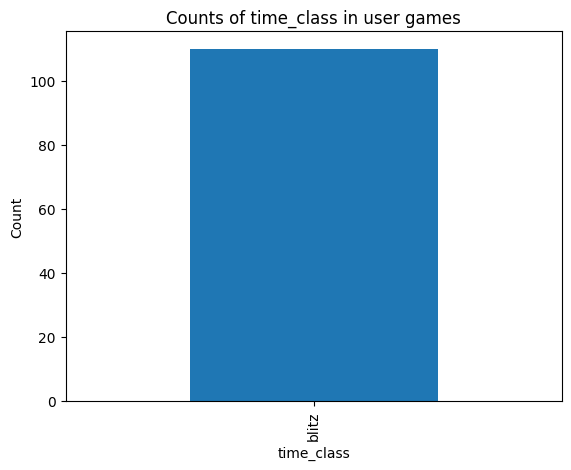

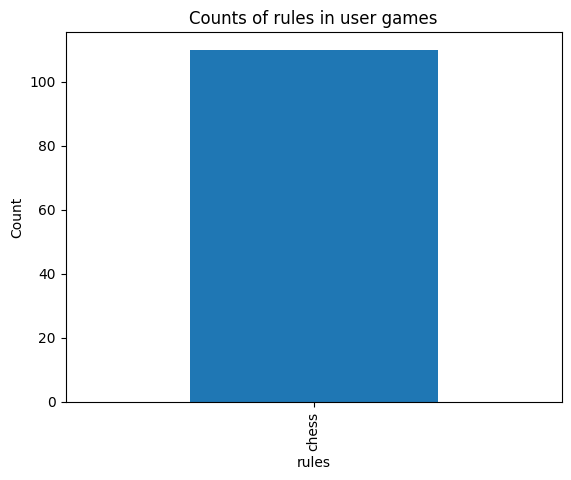

In [3]:
games_info = {
    "time_class": [],
    "rules": [],
}

for game in selected_games:
    games_info["time_class"].append(game["time_class"])
    games_info["rules"].append(game["rules"])
    
df_games_info = pd.DataFrame(games_info)

for col in df_games_info.columns:
    counts = df_games_info[col].value_counts()
    counts.plot(kind='bar', title=f"Counts of {col} in user games")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()
    

In [4]:
found_players = set()
for game in selected_games:
    found_players.add(game["white"]["username"].lower())
    found_players.add(game["black"]["username"].lower())
print(f"Number of unique players found in games: {len(found_players)}")

print(list(found_players)[0:10])

Number of unique players found in games: 220
['angry_twin', 'shuvalov', 'hikaru', 'archess2', 'anton_demchenko', 'sassy_strawberry', 'zeitnot593', 'jospem', 'b_6', 'matthewg-p4p']


In [5]:
chess_games = [game for game in selected_games if game["time_class"] == "blitz" and game["rules"] == "chess"]

# chess_games = []
# top_players_usernames = ["hikaru", "magnuscarlsen", "firouzja2003", "gukeshdommaraju", "lachesisq", "fabianocaruana", "hansontwitch"]
# for game in selected_games:
#     if str(game["white"]["username"]).lower() in top_players_usernames or str(game["black"]["username"]).lower() in top_players_usernames:
#         chess_games.append(game)

print(f"Number of chess games: {len(chess_games)}")

Number of chess games: 110


Select a subset of games

In [6]:
chess_games = random.sample(chess_games, 10)

print("Number of chess games after sampling: ", len(chess_games))

Number of chess games after sampling:  10


Test a game

In [7]:
game_number = 1
user_game = selected_games[game_number]
user_game_pgn = user_game["pgn"]
print("Game PGN: ", user_game_pgn)
print("Type: ", type(user_game_pgn))

Game PGN:  [Event "Live Chess"]
[Site "Chess.com"]
[Date "2025.05.13"]
[Round "-"]
[White "Hikaru"]
[Black "HansOnTwitch"]
[Result "0-1"]
[Tournament "https://www.chess.com/tournament/live/late-titled-tuesday-blitz-may-13-2025-5643227"]
[CurrentPosition "1k1r3r/ppp1q3/8/1PNb1pb1/P7/2QPP1pp/4BP1R/2R1K3 w - - 0 27"]
[Timezone "UTC"]
[ECO "A01"]
[ECOUrl "https://www.chess.com/openings/Nimzowitsch-Larsen-Attack-Modern-Variation...4.e3-d5-5.cxd5-Nxd5-6.a3"]
[UTCDate "2025.05.13"]
[UTCTime "22:08:11"]
[WhiteElo "3375"]
[BlackElo "3223"]
[TimeControl "180+1"]
[Termination "HansOnTwitch won by resignation"]
[StartTime "22:08:11"]
[EndDate "2025.05.13"]
[EndTime "22:13:19"]
[Link "https://www.chess.com/game/live/141487869561"]

1. b3 {[%clk 0:03:00.9]} 1... e5 {[%clk 0:02:58.7]} 2. Bb2 {[%clk 0:03:01.2]} 2... Nc6 {[%clk 0:02:59.3]} 3. c4 {[%clk 0:03:01.7]} 3... Nf6 {[%clk 0:02:58.1]} 4. e3 {[%clk 0:03:01.9]} 4... d5 {[%clk 0:02:58.3]} 5. cxd5 {[%clk 0:03:02.8]} 5... Nxd5 {[%clk 0:02:58.9]} 6. a

Headers(Event='Live Chess', Site='Chess.com', Date='2025.05.13', Round='-', White='Hikaru', Black='HansOnTwitch', Result='0-1', Tournament='https://www.chess.com/tournament/live/late-titled-tuesday-blitz-may-13-2025-5643227', CurrentPosition='1k1r3r/ppp1q3/8/1PNb1pb1/P7/2QPP1pp/4BP1R/2R1K3 w - - 0 27', Timezone='UTC', ECO='A01', ECOUrl='https://www.chess.com/openings/Nimzowitsch-Larsen-Attack-Modern-Variation...4.e3-d5-5.cxd5-Nxd5-6.a3', UTCDate='2025.05.13', UTCTime='22:08:11', WhiteElo='3375', BlackElo='3223', TimeControl='180+1', Termination='HansOnTwitch won by resignation', StartTime='22:08:11', EndDate='2025.05.13', EndTime='22:13:19', Link='https://www.chess.com/game/live/141487869561')
White:  Hikaru
Black:  HansOnTwitch


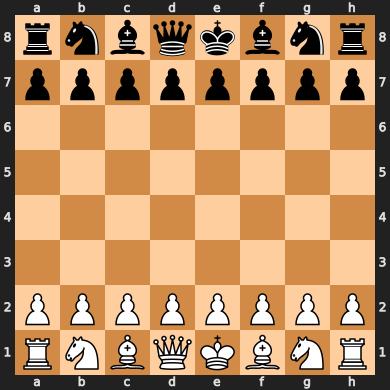

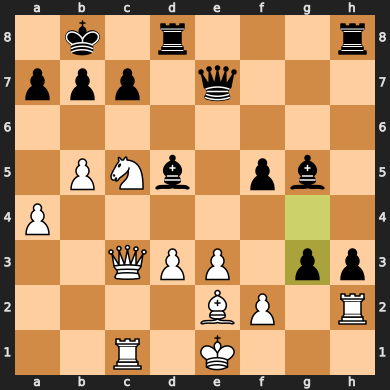

In [8]:
pgn = io.StringIO(user_game_pgn)
chess_game = chess.pgn.read_game(pgn)

# Headers (metadata)
print(chess_game.headers)

# Players
print("White: ", chess_game.headers["White"])
print("Black: ", chess_game.headers["Black"])


# Initial boardboard = chess_game.board()
board = chess_game.board()
display(board)

# Final board
board = chess_game.end().board()
display(board)

In [9]:
# Get dictionary mapping square indices to pieces
pieces_map = board.piece_map()
pieces_map = {k: v.symbol() for k, v in pieces_map.items()}

PIECES_NUMBERS = [
    56, 57, 58, 59, 60, 61, 62, 63,
    48, 49, 50, 51, 52, 53, 54, 55,
    40, 41, 42, 43, 44, 45, 46, 47,
    32, 33, 34, 35, 36, 37, 38, 39,
    24, 25, 26, 27, 28, 29, 30, 31,
    16, 17, 18, 19, 20, 21, 22, 23,
    8, 9, 10, 11, 12, 13, 14, 15,
    0, 1, 2, 3, 4, 5, 6, 7
]

SQUARE_NOTATION = [
    "a8", "b8", "c8", "d8", "e8", "f8", "g8", "h8",
    "a7", "b7", "c7", "d7", "e7", "f7", "g7", "h7",
    "a6", "b6", "c6", "d6", "e6", "f6", "g6", "h6",
    "a5", "b5", "c5", "d5", "e5", "f5", "g5", "h5",
    "a4", "b4", "c4", "d4", "e4", "f4", "g4", "h4",
    "a3", "b3", "c3", "d3", "e3", "f3", "g3", "h3",
    "a2", "b2", "c2", "d2", "e2", "f2", "g2", "h2",
    "a1", "b1", "c1", "d1", "e1", "f1", "g1", "h1"
]

pieces_squares = list(map(lambda x: pieces_map.get(x, "0"), PIECES_NUMBERS))

pieces_arr = np.array(pieces_squares).reshape(8, 8)

print(pieces_arr)

[['0' 'k' '0' 'r' '0' '0' '0' 'r']
 ['p' 'p' 'p' '0' 'q' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0']
 ['0' 'P' 'N' 'b' '0' 'p' 'b' '0']
 ['P' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' 'Q' 'P' 'P' '0' 'p' 'p']
 ['0' '0' '0' '0' 'B' 'P' '0' 'R']
 ['0' '0' 'R' '0' 'K' '0' '0' '0']]


Split in train, test, and validation (Holdout)

In [10]:
games_idxs = list(range(len(chess_games)))

train_games, test_games = train_test_split(games_idxs, test_size=0.3, random_state=42)
test_games, validation_games = train_test_split(test_games, test_size=0.4, random_state=42)

print(f"Number of train games: {len(train_games)}")
print(f"Number of test games: {len(test_games)}")
print(f"Number of validation games: {len(validation_games)}")

Number of train games: 7
Number of test games: 1
Number of validation games: 2


Process games

In [ ]:
def get_game_info(game_number):
    game_json = selected_games[game_number]
    game_pgn = game_json["pgn"]
    player_white = game_json["white"]
    player_black = game_json["black"]
    
    return {
        "pgn": game_pgn,
        "white": player_white,
        "black": player_black
    }
    
def board2arr(board):
    pieces_map = board.piece_map()
    pieces_map = {k: v.symbol() for k, v in pieces_map.items()}

    PIECES_NUMBERS = [
        56, 57, 58, 59, 60, 61, 62, 63,
        48, 49, 50, 51, 52, 53, 54, 55,
        40, 41, 42, 43, 44, 45, 46, 47,
        32, 33, 34, 35, 36, 37, 38, 39,
        24, 25, 26, 27, 28, 29, 30, 31,
        16, 17, 18, 19, 20, 21, 22, 23,
        8, 9, 10, 11, 12, 13, 14, 15,
        0, 1, 2, 3, 4, 5, 6, 7
    ]

    pieces_squares = list(map(lambda x: pieces_map.get(x, "0"), PIECES_NUMBERS))

    pieces_arr = np.array(pieces_squares).reshape(8, 8)

    return pieces_arr

def get_board_representation(board):
    """Converts a chess.Board object to a 2D list representation."""
    board_str = str(board).replace(' ', '')
    rows = board_str.split('\n')
    board_repr = [list(row) for row in rows]
    return board_repr

def draw_board(board_repr, piece_paths, board_colors, player_pov="white", size=400):
    """
    Draws a chessboard with pieces loaded from image files.

    Args:
        board_repr (list): 2D list representing the board state.
        piece_paths (dict): Dictionary mapping piece symbols to image file paths.
        board_colors (tuple | List[tuple]): A tuple or list of tuples representing (light_square_color, dark_square_color).
        player_pov (str): The perspective of the board ('white' or 'black').
        size (int): The size of the board image in pixels.
    """
    if player_pov == "black":
        board_repr = board_repr[::-1]
        board_repr = [row[::-1] for row in board_repr]

    # Set board colors
    if isinstance(board_colors, list):
        board_colors = random.choice(board_colors) # Choose a random color scheme
    
    img = Image.new('RGB', (size, size), 'white')
    draw = ImageDraw.Draw(img)
    
    square_size = size // 8
    light_color, dark_color = board_colors
    
    # Draw squares
    for row in range(8):
        for col in range(8):
            x1, y1 = col * square_size, row * square_size
            x2, y2 = x1 + square_size, y1 + square_size
            color = light_color if (row + col) % 2 == 0 else dark_color
            draw.rectangle([x1, y1, x2, y2], fill=color)
            
    # Place pieces
    for row in range(8):
        for col in range(8):
            piece_symbol = board_repr[row][col]
            if piece_symbol != '.' and piece_symbol in piece_paths:
                # Open the piece image from the file path
                piece_img = Image.open(piece_paths[piece_symbol])
                
                # Resize piece to fit the square
                piece_img = piece_img.resize((square_size, square_size), Image.Resampling.LANCZOS)
                
                x, y = col * square_size, row * square_size
                
                # Paste the piece, using its alpha channel for transparency
                if piece_img.mode == 'RGBA':
                    img.paste(piece_img, (x, y), piece_img)
                else:
                    img.paste(piece_img, (x, y))

    return img

def process_game(game_info, imgs_dir, labels_dir, piece_paths, board_colors):


    # Settings
    player_pov = "white"

    # Instantiate a chess game
    pgn = io.StringIO(game_info["pgn"])
    chess_game = chess.pgn.read_game(pgn)
    board = chess_game.board()

    # --- Render initial position (before any moves) ---
    board_array = get_board_representation(board)
    img_board = draw_board(board_array, piece_paths, board_colors, player_pov=player_pov)
    name = f"{game_info['white']['username']}_{game_info['black']['username']}_000"
    img_path = os.path.join(imgs_dir, name + ".png")
    img_board.save(img_path, "PNG")
    pieces_arr = board2arr(board)
    np.savetxt(os.path.join(labels_dir, f"{name}.csv"), pieces_arr, delimiter=",", fmt="%s")
    
    # Iterate through moves and generate images and labels
    for i, move in enumerate(list(chess_game.mainline_moves())):
        #print(f"Move {i + 1}: {move}")
        board.push(move)
        
        # Get the 2D list representation of the board
        board_array = get_board_representation(board)

        # Render the board with your custom PNG pieces
        img_board = draw_board(board_array, piece_paths, board_colors, player_pov=player_pov)

        # Apply a level of blur randomly
        # if random.random() < 0.5:  # 50% chance to apply blur
        #     img_board = img_board.filter(ImageFilter.GaussianBlur(radius=2))

        radius = random.randint(0, 2)
        img_board = img_board.filter(ImageFilter.GaussianBlur(radius=radius))

        # Save as PNG
        name = f"{game_info['white']['username']}_{game_info['black']['username']}_{i + 1:03d}"
        img_path = os.path.join(imgs_dir, name + ".png")
        img_board.save(img_path, "PNG")

        # Generate fen and save labels
        #fen = board.fen()
        
        # Get arrays of pieces
        pieces_arr = board2arr(board)
        # Save pieces array to CSV
        np.savetxt(os.path.join(labels_dir, f"{name}.csv"), pieces_arr, delimiter=",", fmt="%s")


def create_split_directory(split_dir):
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

    img_dir = split_dir / "images"
    labels_dir = split_dir / "labels"
    
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
        
    if not os.path.exists(labels_dir):
        os.makedirs(labels_dir)
        
    return img_dir, labels_dir

def create_labels_mapping(save_dir):
    
    board = chess.Board()
    
    pieces_arr = board2arr(board)
    
    class_names = sorted(list(set(pieces_arr.flatten())))
    
    class2id = {name: id for id, name in enumerate(class_names)}
    id2class = {id: name for name, id in class2id.items()}
    
    map_path = save_dir / "labels_mapping.json"
    with open(map_path, 'w') as f:
        json.dump({
            "class2id": class2id,
            "id2class": id2class
        }, f, indent=4)


def process_games():

    # Default chess.com color layout
    #BOARD_COLORS = ("#EBECD3", "#7D945D")

    # Multiple color schemes
    BOARD_COLORS_LIST = [
        ("#EBECD3", "#7D945D"),
        ("#B98F4E", "#805531"),
        ("#6A7383", "#292E3B"),
        ("#EDD6B0", "#B88762"),
        ("#D8E3E7", "#789BB0"),
        ("#F5DBC3", "#BB5746"),
        ("#E5E3DE", "#306448")
    ]
    
    try:
        # This works in .py files
        base_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        # Fallback for Jupyter notebooks
        base_dir = os.getcwd()
        
    save_dir = pathlib.Path(base_dir).parent / "data" / "chessboard_2d_rendered_aug"


    # Pieces images
    current_dir = pathlib.Path()
    pieces_dir = current_dir / "piece_images"
    pieces_dir.mkdir(exist_ok=True)
    piece_paths = {
    'K': pieces_dir / "wK.png", 'Q': pieces_dir / "wQ.png", 'R': pieces_dir / "wR.png",
    'B': pieces_dir / "wB.png", 'N': pieces_dir / "wN.png", 'P': pieces_dir / "wP.png",
    'k': pieces_dir / "bK.png", 'q': pieces_dir / "bQ.png", 'r': pieces_dir / "bR.png",
    'b': pieces_dir / "bB.png", 'n': pieces_dir / "bN.png", 'p': pieces_dir / "bP.png",
}
    
    # Train games
    train_dir = save_dir / "train"
    train_imgs_dir, train_labels_dir = create_split_directory(train_dir)
    print(f"Train images directory: {train_imgs_dir}")
    print(f"Train labels directory: {train_labels_dir}")
    
    # Test games
    test_dir = save_dir / "test"
    test_imgs_dir, test_labels_dir = create_split_directory(test_dir)
    
    # Validation games
    val_dir = save_dir / "validation"
    val_imgs_dir, val_labels_dir =  create_split_directory(val_dir)
    
    # Create labels mapping
    create_labels_mapping(save_dir)
    
    # Process train games
    for game_idx in tqdm(train_games, desc="Processing train games"):
        game_info = get_game_info(game_idx)
        process_game(game_info, train_imgs_dir, train_labels_dir, piece_paths=piece_paths, board_colors=BOARD_COLORS_LIST)

    # Process test games
    for game_idx in tqdm(test_games, desc="Processing test games"):
        game_info = get_game_info(game_idx)
        process_game(game_info, test_imgs_dir, test_labels_dir, piece_paths=piece_paths, board_colors=BOARD_COLORS_LIST)
        
    # Process validation games
    for game_idx in tqdm(validation_games, desc="Processing validation games"):
        game_info = get_game_info(game_idx)
        process_game(game_info, val_imgs_dir, val_labels_dir, piece_paths=piece_paths, board_colors=BOARD_COLORS_LIST)
        
    print("Processing completed!")
    
process_games()

Train images directory: /Users/alexquiroga/Storage/Github/DEEP_LEARNING/COMPUTER_VISION/chess-vision/chess-main/data/chessboard_2d_rendered_aug/train/images
Train labels directory: /Users/alexquiroga/Storage/Github/DEEP_LEARNING/COMPUTER_VISION/chess-vision/chess-main/data/chessboard_2d_rendered_aug/train/labels


Processing validation games: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

Processing completed!
